# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [61]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [62]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [63]:
# And an initial condition (with SI units)

r_0 = 147e9 * m
v_0 = -30330 * m/s

init = State(x = r_0,
             y = 0 * m,
             vx = 0 * m / s,
             vy = 0 * m / s)

,values
x,147000000000.0 meter
y,0 meter
vx,0.0 meter / second
vy,0.0 meter / second


In [64]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=31556925.9747 * s)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,31556925.9747 second


In [65]:
# This function computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """
    x, y, vx, vy = state
    unpack(system)
    r = Vector(x, y)
    v = Vector(vx, vy)
 
    force_mag = G * m1 * m2 / r.mag**2
    force = r.hat() * force_mag 
   # force = Vector(G*m1*m2/x**2, G*m1*m2/y**2)
    return force

In [66]:
universal_gravitation(init, system)

<Quantity([3.6686486e+22 0.0000000e+00], 'newton')>

In [67]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    

    force_x, force_y = universal_gravitation(state, system)
    dxdt = vx
    dydt = vy
    dvxdt = -force_x / m2
    dvydt = -force_y / m2
    
    return dxdt, dydt, dvxdt, dvydt

In [68]:
# Testing the slope function

slope_func(init, 0, system)

(<Quantity(0.0, 'meter / second')>,
 <Quantity(0.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [69]:
# Event function that stops the simulation upon collision

def event_func(state, t, system):
    x, y, vx, vy = state
    position = Vector(x,y)
    return position.mag - system.r_final

In [70]:
# Testing the event function

events = event_func(init, 0, system)

<Quantity(146298121000.0, 'meter')>

In [71]:
# Running the simulation

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[5432693.073385954]]
nfev,182
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [72]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(5432693.073385954, 'second')>

In [73]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(62.87839205307816, 'day')>

In [74]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, t_eval=ts)

In [75]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [76]:
# Scaling the distance to million km

r = sqrt(results.y**2+results.x**2) / 1e9 

0.000000     147.000000
0.314392     146.997734
0.628784     146.990934
0.943176     146.979602
1.257568     146.963735
1.571960     146.943334
1.886352     146.918396
2.200744     146.888920
2.515136     146.854905
2.829528     146.816349
3.143920     146.773248
3.458312     146.725601
3.772704     146.673404
4.087095     146.616654
4.401487     146.555348
4.715879     146.489482
5.030271     146.419052
5.344663     146.344052
5.659055     146.264479
5.973447     146.180328
6.287839     146.091593
6.602231     145.998268
6.916623     145.900348
7.231015     145.797827
7.545407     145.690698
7.859799     145.578953
8.174191     145.462587
8.488583     145.341592
8.802975     145.215960
9.117367     145.085683
                ...    
53.761025     64.543559
54.075417     63.225930
54.389809     61.883488
54.704201     60.515335
55.018593     59.120541
55.332985     57.697445
55.647377     56.243130
55.961769     54.757273
56.276161     53.239230
56.590553     51.687785
56.904945     50

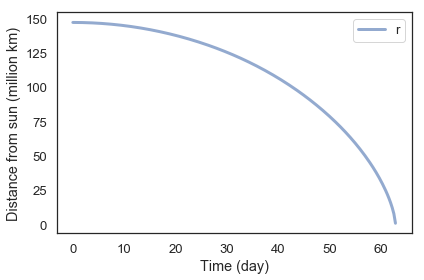

In [77]:
# And plotting

plot(r, label='r')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

In [78]:
# Now, we change our initial velocity to match the real orbit 
# of the Earth, so that it actually orbits and doesn't fall

init = State(x = r_0,
             y = 0 * m,
             vx = 0 * m / s,
             vy = v_0)

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end=31556925.9747 * s)

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,31556925.9747 second


In [79]:
#And test again!

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[]]
nfev,152
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [80]:
#So our final time should be a full year, which is how many seconds we started with!

t_final = get_last_label(results) * s

<Quantity(31556925.9747, 'second')>

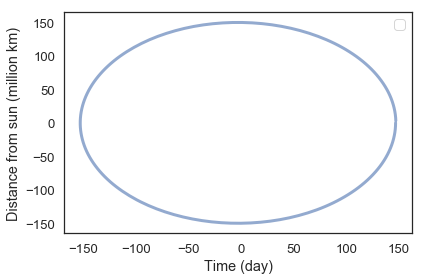

In [81]:
#This function makes the plot smoother by evaluating results more per amount of time
ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, method='RK23', t_eval=ts)

#Scaled to days!
results.index /= 60 * 60 * 24

#And to millions of km!
x = results.x / 1e9;
y = results.y /1e9;
plot(x, y)

#Plotted :)
decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')